***Implementation of Conditional GAN***

To overcome the problem of blurry images in DCGAN and Vanilla GAN due to multimodal distribution we implement a conditional GAN on MNIST dataset. The results after 200 epochs are pretty good. Some white pixels appear at places in images. To prevent that we will be implementing Conditional DCGAN


Variable Naming Convention

* dis/d= discriminator  
* gen/g= generator  
* f=fake  
* r=real  
* t=total  
* a=average  
* corr=correct  
* opt=optimizer

In [0]:
import torch
from torch import nn, optim
from torch.autograd.variable import Variable
import torchvision.utils as vutils
from torchvision import transforms, datasets
from IPython import display
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import cv2
import os
from google.colab import drive,files
import glob


In [3]:
drive.mount('/content/drive')


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
# !git clone 'https://github.com/fyu/lsun.git'
# !python3 /content/lsun/download.py -c 'church_outdoor'
# !mkdir /content/lsun/lsun
# !mkdir /content/lsun/lsun/church_outdoor
# !unzip '/content/church_outdoor_train_lmdb.zip' -d '/content/lsun/lsun'

In [0]:
#For visualising,displaying,saving and loading puposes

class Logger:

  def __init__(self,img_path,model_path):
    self.image_folder=img_path
    self.model_path=model_path

  #Function For plotting data
  def _plot_function(self,list_d_error, list_g_error, list_d_acc_real, list_d_acc_fake,num_ex,type='error'):
    fig = plt.figure()
    plt.xlabel('number of training examples seen')

    if(type=='error'):
        plt.plot(num_ex,list_g_error,  color='blue',zorder=0)
        plt.plot(num_ex,list_d_error,  color='red',zorder=10)
        plt.legend(['gen error', 'disc error'], loc='upper right')
        plt.ylabel('Error')
    else:
        plt.plot(num_ex,list_d_acc_real, color='blue',zorder=0)
        plt.plot(num_ex, list_d_acc_fake,   color='red',zorder=10)
        plt.legend(['accuracy real', 'accuracy fake'], loc='upper right')
        plt.ylabel('Accuracy Discrimination')
    plt.plot()



  def plot(self,list_d_error, list_g_error, list_d_acc_real, list_d_acc_fake,num_ex):
    self._plot_function(list_d_error, list_g_error, list_d_acc_real, list_d_acc_fake,num_ex,'error')
    self._plot_function(list_d_error, list_g_error, list_d_acc_real, list_d_acc_fake,num_ex,'accuracy')
    plt.show(block=False)

  #Functions for making and downloading video
  def make_videos(self,fps=10):

    images = [img for img in os.listdir(self.image_folder) if (img.endswith(".png") and 'test' not in img)]
    images=sorted(images)

    self._make_video(images,'video1.avi',fps)
    self._convert_avi_to_mp4('./video1.avi','video1')
  

  def _make_video(self,images,video_name,fps):

    frame = cv2.imread(os.path.join(self.image_folder, images[0]))
    height, width, layers = frame.shape
    video = cv2.VideoWriter(video_name, 0, fps, (width,height))

    for image in images:
        video.write(cv2.imread(os.path.join(self.image_folder, image)))

    cv2.destroyAllWindows()
    video.release()

  
  def _convert_avi_to_mp4(self,avi_file_path, output_name):
    os.popen("ffmpeg -i '{input}' -ac 2 -b:v 2000k -c:a aac -c:v libx264 -b:a 160k -vprofile high -bf 0 -strict experimental -f mp4 '{output}.mp4'".format(input = avi_file_path, output = output_name))
    return True

  #Function for logging training status
  def log(self, epoch, ad_error, ag_error, ad_acc_real, ad_acc_fake,n_batch=None):

    print('Epoch: {}'.format(epoch),end='  ')          
    if n_batch is not None:
      print('[{}/{}]'.format(n_batch, num_batches),end='  ')              
    print('Discriminator Loss: {:.4f}, Generator Loss: {:.4f}, accuracy for real images: {:.2f}%, accuracy for fake images: {:.2f}%'.format(ad_error, ag_error,ad_acc_real, ad_acc_fake))

  #Function for saving the model
  def save_model(self,list_d_error, list_g_error, list_d_acc_real, list_d_acc_fake,num_ex):

    path=self.model_path

    torch.save(dnet.state_dict(), path+'/dnet.pth')
    torch.save(dopt.state_dict(), path+'/dopt.pth')
    torch.save(gnet.state_dict(), path+'/gnet.pth')
    torch.save(gopt.state_dict(), path+'/gopt.pth')

    d_error_np=np.array(list_g_error)
    g_error_np=np.array(list_d_error)
    fake_acc_np=np.array(list_d_acc_real)
    real_acc_np=np.array(list_d_acc_fake)
    num_ex_np=np.array(num_ex)



    graph_tr_data=pd.DataFrame({'d_error_np':d_error_np,
                            'g_error_np':g_error_np,
                          'fake_acc_np':fake_acc_np,
                            'real_acc_np':real_acc_np,
                            'num_ex_np':num_ex_np
                                })
    
    

    graph_tr_data.to_csv(path+'/graph_trainig_data.csv')

  #Function for loading the model
  def load_model(self):

    path=self.model_path

    dnet,gnet,dopt,gopt,test_noise,list_d_error, list_g_error, list_d_acc_real, list_d_acc_fake,num_ex=create_model()

    gen_state_dict = torch.load(path+'/gnet.pth')
    gnet.load_state_dict(gen_state_dict)

    dis_state_dict = torch.load(path+'/dnet.pth')
    dnet.load_state_dict(dis_state_dict)

    dopt_state_dict = torch.load(path+'/dopt.pth')
    dopt.load_state_dict(dopt_state_dict)

    gopt_state_dict = torch.load(path+'/gopt.pth')
    gopt.load_state_dict(gopt_state_dict)

    graph_trainig_data=pd.read_csv(path+'/graph_trainig_data.csv')

                
    g_error_np=np.array(graph_trainig_data['g_error_np'])
    d_error_np=np.array(graph_trainig_data['d_error_np'])
    fake_acc_np=np.array(graph_trainig_data['fake_acc_np'])
    real_acc_np=np.array(graph_trainig_data['real_acc_np'])
    num_ex_np=np.array(graph_trainig_data['num_ex_np'])


    list_g_error=list(g_error_np)
    list_d_error=list(d_error_np)
    list_d_acc_fake=list(fake_acc_np)
    list_d_acc_real=list(real_acc_np)
    num_ex=list(num_ex_np)

    st=num_ex[-1]//num_train +1

    return dnet,gnet,dopt,gopt,test_noise,list_d_error, list_g_error, list_d_acc_real, list_d_acc_fake,num_ex,st

  #Function for displaying and saving images
  def show_images(self,epoch,batch=None,save=True):

    images = toimg(gnet(test_data[0],test_data[1]))

    # Plot and save horizontal
    horizontal_grid = vutils.make_grid(
            images, normalize=True, scale_each=True,nrow=10)
    fig = plt.figure(figsize=(10, 10))
    plt.imshow(np.moveaxis(horizontal_grid.detach().cpu().numpy(), 0, -1))
    plt.axis('off')
    display.display(plt.gcf())
    if save:self._save_images(fig, epoch,batch,)
    plt.close()

  def _save_images(self, fig, epoch, batch, comment=''):
    epoch=str(epoch)
    epoch=('000000'+epoch)[-4:]  # Changes 1 to 0001, 11 to 0011 and so on
    batch=str(batch)
    batch=('000000'+batch)[-4:]  # Changes 1 to 0001, 11 to 0011 and so on
    img_name='/image_{}{}_{}'.format(comment,epoch,batch)
    fig.savefig(self.image_folder+img_name)

logger=Logger(img_path,model_path)

In [134]:
#Global Variables Initialisation

H=28
W=28
C=1
HW=H*W
noise_dim=100
batch_size=64
num_test_samples = 100
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_path='/content/drive/My Drive/Colab Notebooks/data_files/C_GAN_MNIST/'
img_path='/content/drive/My Drive/Colab Notebooks/data_files/C_GAN_MNIST/img/'
loss=nn.BCELoss(reduction='sum')
print(device)

cuda


In [0]:
#Make relevant folders

if not os.path.isdir(model_path):
    os.makedirs(model_path)
    print('Directory doesn\'t exist! creating one....')

if not os.path.isdir(img_path):
    os.makedirs(img_path)
    print('Directory doesn\'t exist! creating one....')


In [0]:
#loading data

transform= transforms.Compose([     
                                    transforms.ToTensor(),
                                    transforms.Normalize((0.5,),(0.5,))
  ])

dataset_train=datasets.MNIST(root='/dataset/', download=True,transform=transform)
dataset_test=datasets.MNIST(root='/dataset/', train=False,download=True,transform=transform)

dataset=torch.utils.data.ConcatDataset([dataset_train,dataset_test])





In [137]:
dataloader=torch.utils.data.DataLoader(dataset,batch_size=batch_size,shuffle=True)
num_batches=len(dataloader)
num_train=len(dataset)
print(num_train,num_batches)

70000 1094


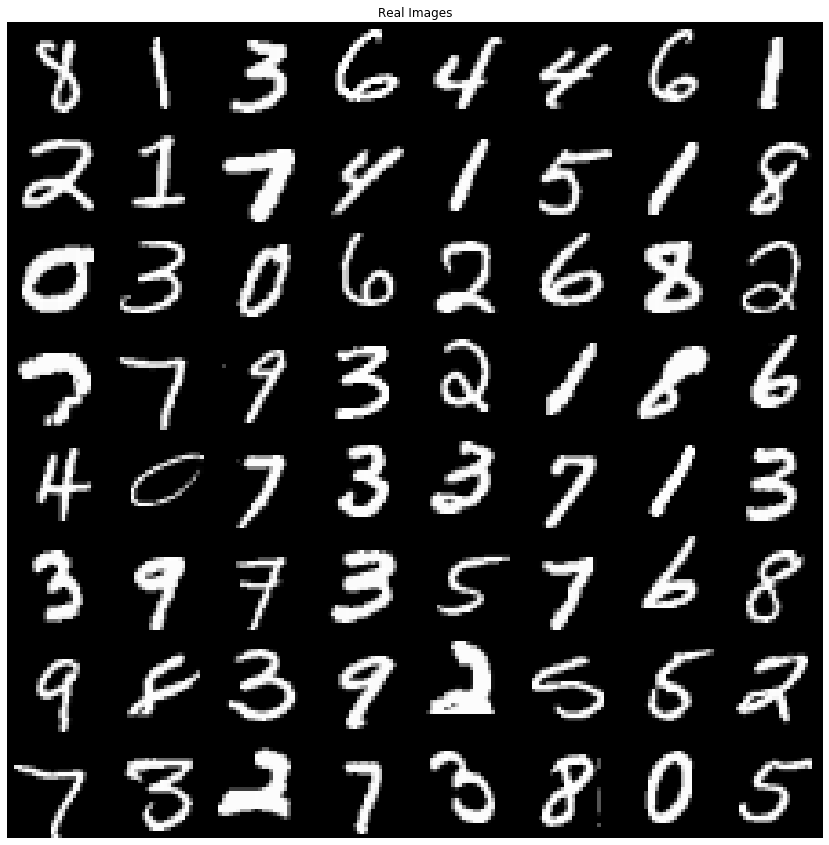

In [138]:
#visualise real images
real_batch = next(iter(dataloader))

# Plot the real images
fig=plt.figure(figsize=(15,15))
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device), padding=0, normalize=True).cpu(),(1,2,0)))
plt.show()

In [0]:
#Utils Functions

def flatten(x):
  return x.view(-1,HW*C)

def toimg(x):
  return x.view(-1,C,H,W)

def ones(size):
  return (torch.ones((size,1),device=device))

def zeros(size):
  return (torch.zeros((size,1),device=device))

def noise(size):
  return (torch.randn((size,noise_dim),device=device))

def noise_labels(size):
  return one_hot(torch.arange(size,device=device)%10)


def one_hot(labels):
  N=labels.shape[0]
  one_hot = torch.zeros(N, 10)
  one_hot[torch.arange(N), labels] = 1
  return one_hot.to(device)



In [0]:
#Function to train discriminator

def train_dis(dopt,real,fake,one_hot_labels):

  N=real.shape[0]
  
  dopt.zero_grad()

  pred_r=dnet(real,one_hot_labels)
  error_r=loss(pred_r,ones(N))
  error_r.backward()

  corr_r= pred_r > 0.5
  t_corr_r=torch.sum(corr_r==ones(N)).type(torch.FloatTensor)

  pred_f=dnet(fake,one_hot_labels)
  error_f=loss(pred_f,zeros(N))
  error_f.backward()

  corr_f=pred_f < 0.5
  t_corr_f=torch.sum(corr_f==ones(N)).type(torch.FloatTensor)

  dopt.step()

  return (error_r+error_f)/2,t_corr_r,t_corr_f


In [0]:
#Function to train generator

def train_gen(gopt,fake,one_hot_labels):
  
  N=fake.shape[0]
  
  gopt.zero_grad()

  pred=dnet(fake,one_hot_labels)
  error=loss(pred,ones(N))
  error.backward()

  gopt.step()

  return error

In [0]:
#Function to perform a specific number of train epochs

def train(num_epochs ,log_interval=500,save=True):

  global st

  ad_error, ag_error, ad_acc_real, ad_acc_fake=0,0,0,0,
  
  if(st==1):
    logger.show_images(epoch=1,batch=0)

  for epoch in range(st,st+num_epochs): 


    td_error, tg_error, td_acc_real, td_acc_fake=0,0,0,0

    for n_batch, (real_data,real_labels) in enumerate(dataloader):


      N=real_data.shape[0]

      real_data=real_data.to(device)
      real_labels=real_labels.to(device)


      one_hot_labels=one_hot(real_labels)

      fake_data=gnet(noise(N),one_hot_labels)
      d_error,d_acc_real,d_acc_fake= train_dis(dopt,real_data,fake_data,one_hot_labels)
    
      fake_data=gnet(noise(N),one_hot_labels)
      g_error=train_gen(gopt,fake_data,one_hot_labels)

      td_error+=d_error
      tg_error+=g_error
      td_acc_real+=d_acc_real
      td_acc_fake+=d_acc_fake

      if(n_batch%log_interval==0 and n_batch!=0):
        list_d_error.append(( d_error/N).item())
        list_g_error.append(( g_error/N).item())
        list_d_acc_real.append((d_acc_real*100/N).item())
        list_d_acc_fake.append((d_acc_fake*100/N).item())
        num_ex.append( ((epoch-1)*(num_train)+(n_batch+1)*N))


        logger.log(epoch, d_error/N, g_error/N,d_acc_real*100/N,d_acc_fake*100/N,n_batch=n_batch)

        # log_show(epoch, d_error/N, g_error/N,d_acc_real*100/N,d_acc_fake*100/N,batch=n_batch,save=save )
        # save_plot(list_d_error, list_g_error, list_d_acc_real, list_d_acc_fake,num_ex)


    ad_error=td_error/num_train
    ag_error=tg_error/num_train
    ad_acc_real=100*td_acc_real/num_train
    ad_acc_fake=100*td_acc_fake/num_train

    list_g_error.append(ag_error.item())
    list_d_error.append(ad_error.item())
    list_d_acc_real.append(ad_acc_real.item())
    list_d_acc_fake.append(ad_acc_fake.item() )

    num_ex.append( ((epoch)*num_train))

    log_show(epoch+1, ad_error, ag_error, ad_acc_real, ad_acc_fake,batch=0 )
    save_plot(list_d_error, list_g_error, list_d_acc_real, list_d_acc_fake,num_ex)

  st=st+num_epochs
  

In [0]:
#Self explanatory functions

def log_show(epoch, ad_error, ag_error, ad_acc_real, ad_acc_fake,batch=None,save=True ):

  logger.log(epoch, ad_error, ag_error, ad_acc_real, ad_acc_fake,batch)
  logger.show_images(epoch,batch,save=save)
  

def save_plot(list_d_error, list_g_error, list_d_acc_real, list_d_acc_fake,num_ex):
  logger.save_model(list_d_error, list_g_error, list_d_acc_real, list_d_acc_fake,num_ex)
  logger.plot(list_d_error, list_g_error, list_d_acc_real, list_d_acc_fake,num_ex)

In [0]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [0]:
#Function to create and initialise new model for new training process

def create_model():

  dnet=DiscriminatorNet().to(device)
  gnet=GeneratorNet().to(device)
  dnet.apply(weights_init)
  gnet.apply(weights_init)
  dopt=optim.Adam(dnet.parameters(),lr=0.0002, betas=(0.5, 0.999))
  gopt=optim.Adam(gnet.parameters(),lr=0.0002, betas=(0.5, 0.999))

  test_noise = noise(num_test_samples)
  test_labels= noise_labels(num_test_samples)

  test_data=[test_noise,test_labels]

  dnet.train()
  gnet.train()
  list_d_error, list_g_error, list_d_acc_real, list_d_acc_fake,num_ex=[],[],[],[],[]
  


  return dnet,gnet,dopt,gopt,test_data,list_d_error, list_g_error, list_d_acc_real, list_d_acc_fake,num_ex


In [0]:
# !rm -rf /dataset
# !rm -rf /content/sample_data/

In [0]:
#Discrimator Model

class DiscriminatorNet(torch.nn.Module):

  def __init__(self):
    super(DiscriminatorNet,self).__init__()

    n_features=HW*C
    n_out=1

    self.fc0=nn.Sequential(
        nn.Linear(n_features+10,1024),
        nn.LeakyReLU(0.2),
        nn.Dropout(0.3)
    )

    self.fc1=nn.Sequential(
        nn.Linear(1024,512),
        nn.LeakyReLU(0.2),
        nn.Dropout(0.3)
    )

    self.fc2=nn.Sequential(
        nn.Linear(512,256),
        nn.LeakyReLU(0.2),
        nn.Dropout(0.3)
    )

    self.out=nn.Sequential(
        nn.Linear(256,n_out),
        nn.Sigmoid()
    )



  def forward(self,x,y):
    
    x=flatten(x)
    z=torch.cat((x,y),dim=1)
    z=self.fc0(z)
    z=self.fc1(z)
    z=self.fc2(z)
    z=self.out(z)
    return z



        
        
        


In [0]:
#Generator Net

class GeneratorNet(torch.nn.Module):

  def __init__(self):
    super(GeneratorNet,self).__init__()
    n_features=noise_dim
    n_out=HW*C

    self.fc0=nn.Sequential(
        nn.Linear(n_features+10,256),
        nn.LeakyReLU(0.2),
            )

    self.fc1=nn.Sequential(
        nn.Linear(256,512),
        nn.LeakyReLU(0.2),
    )

    self.fc2=nn.Sequential(
        nn.Linear(512,1024),
        nn.LeakyReLU(0.2),
    )

    self.out=nn.Sequential(
        nn.Linear(1024,n_out),
        nn.Tanh()
    )

  def forward(self,x,y):

    z=torch.cat((x,y),dim=1)
    z=self.fc0(z)
    z=self.fc1(z)
    z=self.fc2(z)
    z=self.out(z)
    z=toimg(z)
    return z

In [0]:
# #Discrimator Model

# class DiscriminatorNet(torch.nn.Module):

#   def __init__(self):
#     super(DiscriminatorNet,self).__init__()

#     self.fwd=nn.Sequential(
#         nn.Conv2d(in_channels=C,out_channels=64,kernel_size=4,stride=2,padding=1,bias=False),
#         nn.LeakyReLU(0.2,inplace=True),
#         nn.Conv2d(in_channels=64,out_channels=128,kernel_size=4,stride=2,padding=1,bias=False),
#         nn.BatchNorm2d(num_features=128),
#         nn.LeakyReLU(0.2,inplace=True),
#         nn.Conv2d(in_channels=128,out_channels=256,kernel_size=4,stride=2,padding=1,bias=False),
#         nn.BatchNorm2d(num_features=256),
#         nn.LeakyReLU(0.2,inplace=True),
#         nn.Conv2d(in_channels=256,out_channels=512,kernel_size=4,stride=2,padding=1,bias=False),
#         nn.BatchNorm2d(num_features=512),
#         nn.LeakyReLU(0.2,inplace=True),
#         nn.Conv2d(in_channels=512,out_channels=1,kernel_size=4,stride=1,padding=0,bias=False),
#         nn.Sigmoid()
#     )

#   def forward(self,x):
    
#     return (self.fwd(toimg(x))).view(-1,1)


        
        
        


In [0]:
# #Generator Model

# class GeneratorNet(torch.nn.Module):

#   def __init__(self):

#     super(GeneratorNet,self).__init__()
#     n_features=noise_dim
    

#     self.fwd=nn.Sequential(
#         nn.ConvTranspose2d(in_channels=100,out_channels=512,kernel_size=4,stride=1,bias=False),
#         nn.BatchNorm2d(num_features=512),
#         nn.ReLU(inplace=True),
#         nn.ConvTranspose2d(in_channels=512,out_channels=256,kernel_size=4,stride=2,padding=1,bias=False),
#         nn.BatchNorm2d(num_features=256),
#         nn.ReLU(inplace=True),
#         nn.ConvTranspose2d(in_channels=256,out_channels=128,kernel_size=4,stride=2,padding=1,bias=False),
#         nn.BatchNorm2d(num_features=128),
#         nn.ReLU(inplace=True),
#         nn.ConvTranspose2d(in_channels=128,out_channels=64,kernel_size=4,stride=2,padding=1,bias=False),
#         nn.BatchNorm2d(num_features=64),
#         nn.ReLU(inplace=True),
#         nn.ConvTranspose2d(in_channels=64,out_channels=C,kernel_size=4,stride=2,padding=1,bias=False),
#         nn.Tanh(),

#     )

#   def forward(self,x):

    
#     return flatten(self.fwd(x.view(-1,100,1,1)))







In [0]:
# code to load a previously trained model

# dnet,gnet,dopt,gopt,test_noise,list_d_error, list_g_error, list_d_acc_real, list_d_acc_fake,num_ex,st=logger.load_model()

In [0]:
#Code to clear everything and initialise a new model

st=1
dnet,gnet,dopt,gopt,test_data,list_d_error, list_g_error, list_d_acc_real, list_d_acc_fake,num_ex=create_model()
# print(dnet)
# print(gnet)

In [151]:
fake_data=gnet(noise(64),one_hot(real_batch[1]).to(device))
output=dnet(fake_data,one_hot(real_batch[1]).to(device))

print(output.shape)
print(fake_data.shape)

torch.Size([64, 1])
torch.Size([64, 1, 28, 28])


In [0]:


# print(device)

# real_data=real_data.to(device)
# one_hot_labels=one_hot(real_labels)



# fake_data=gnet(noise(N),one_hot_labels)

# real=real_data
# fake=fake_data
# opt=dopt

# N=real.shape[0]

# opt.zero_grad()

# pred_r=dnet(real)
# error_r=loss(pred_r,ones(N))
# error_r.backward()

# corr_r= pred_r > 0.5
# t_corr_r=torch.sum(corr_r==ones(N)).type(torch.FloatTensor)

# pred_f=dnet(fake)

# print(pred_f.shape,N)
# error_f=loss(pred_f,zeros(N))
# error_f.backward()

# corr_f=pred_f < 0.5
# t_corr_f=torch.sum(corr_f==ones(N)).type(torch.FloatTensor)

# opt.step()

# d_error,d_acc_real,d_acc_fake= train_dis(dopt,real_data,fake_data)

# fake_data=gnet(noise(N))
# g_error=train_gen(gopt,fake_data)

In [153]:
train(40)

Output hidden; open in https://colab.research.google.com to view.

In [0]:
logger.make_videos(fps=5)

In [159]:
train(40)

Output hidden; open in https://colab.research.google.com to view.

In [0]:
logger.make_videos(fps=5)

In [164]:
train(120)

Output hidden; open in https://colab.research.google.com to view.

In [0]:
logger.make_videos(fps=10)

***Some more fake images Visualisations***

In [0]:
num_epochs=200

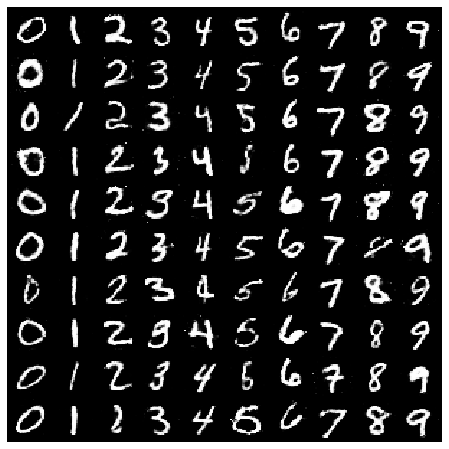

In [169]:
images = toimg(gnet(noise(100),noise_labels(100)))

horizontal_grid = vutils.make_grid(
        images,nrow=10, normalize=True, scale_each=True)
fig = plt.figure(figsize=(8, 8))
plt.imshow(np.moveaxis(horizontal_grid.detach().cpu().numpy(), 0, -1))
plt.axis('off')
fig.savefig(model_path+f'test1-epoch{num_epochs}')

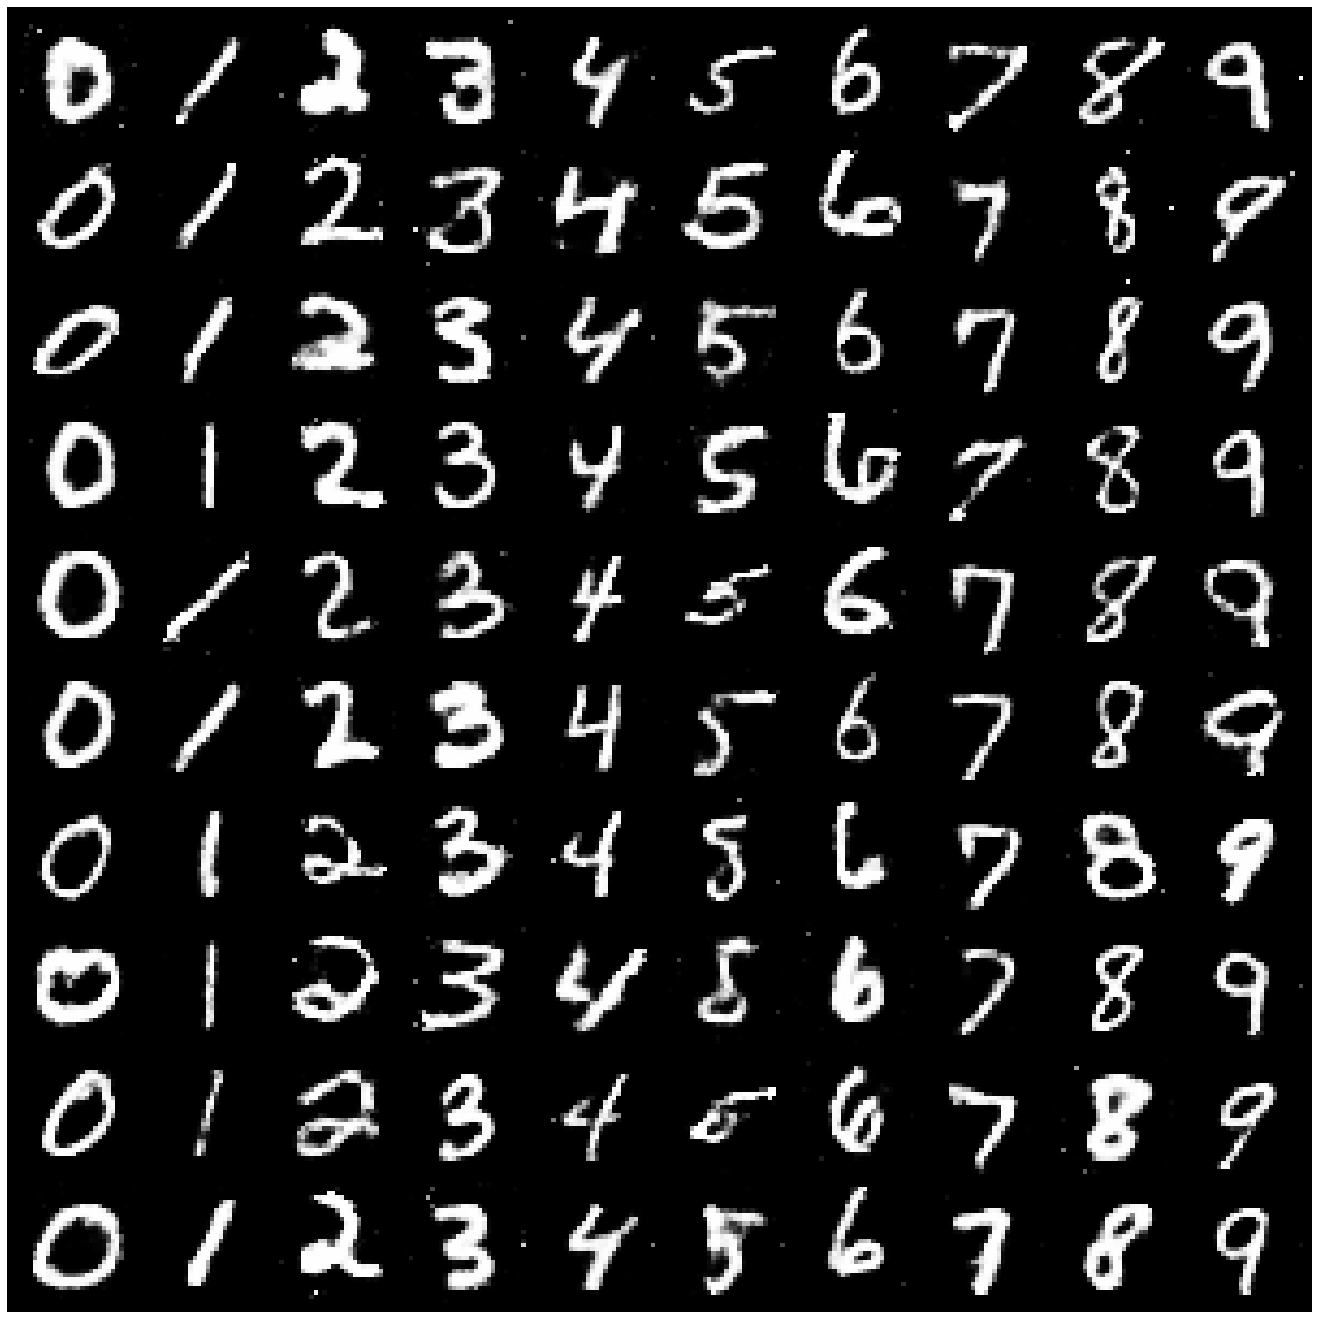

In [172]:
images = toimg(gnet(noise(100),noise_labels(100)))

horizontal_grid = vutils.make_grid(
        images,nrow=10, normalize=True, scale_each=True)
fig = plt.figure(figsize=(24, 24))
plt.imshow(np.moveaxis(horizontal_grid.detach().cpu().numpy(), 0, -1))
plt.axis('off')
fig.savefig(model_path+f'test2-epoch{num_epochs}')

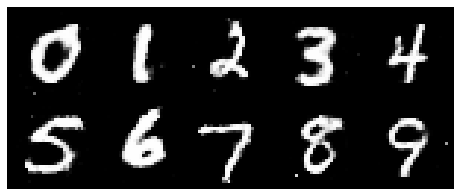

In [173]:
images = toimg(gnet(noise(10),noise_labels(10)))

horizontal_grid = vutils.make_grid(
        images,nrow=5, normalize=True, scale_each=True)
fig = plt.figure(figsize=(8, 8))
plt.imshow(np.moveaxis(horizontal_grid.detach().cpu().numpy(), 0, -1))
plt.axis('off')
fig.savefig(model_path+f'test3-epoch{num_epochs}')

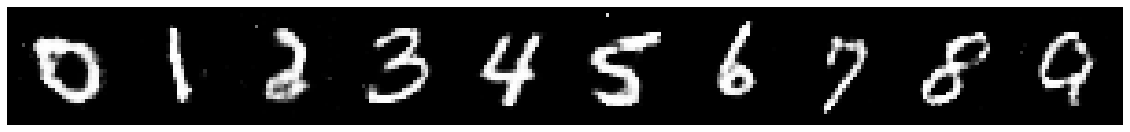

In [174]:
images = toimg(gnet(noise(10),noise_labels(10)))

horizontal_grid = vutils.make_grid(
        images,nrow=10, normalize=True, scale_each=True)
fig = plt.figure(figsize=(20, 20))
plt.imshow(np.moveaxis(horizontal_grid.detach().cpu().numpy(), 0, -1))
plt.axis('off')
fig.savefig(model_path+f'test4-epoch{num_epochs}')

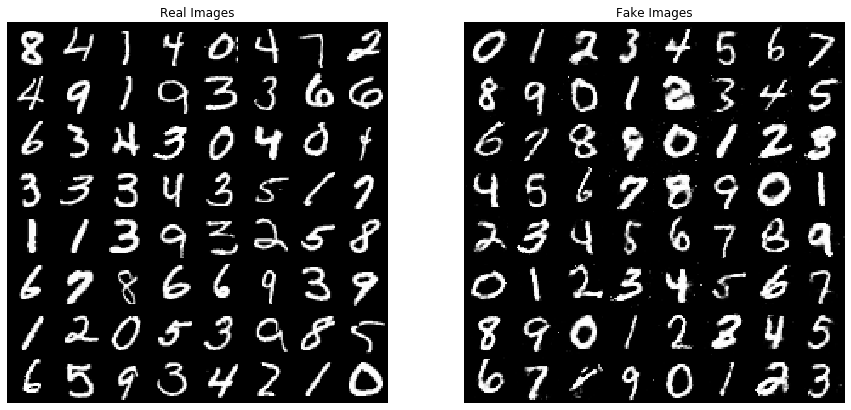

In [175]:
real_batch = next(iter(dataloader))

# Plot the real images
fig=plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=0, normalize=True).cpu(),(1,2,0)))

# Plot the fake images
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
fake = toimg(gnet(noise(64),noise_labels(64))).detach()
plt.imshow(np.transpose(vutils.make_grid(fake, padding=0, normalize=True).cpu(),(1,2,0)))
plt.show()
fig.savefig(model_path+f'test5-epoch{num_epochs}')

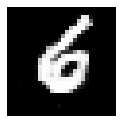

In [188]:
number= 6 #Enter the number to display

images = toimg(gnet(noise(1),noise_labels(10)[number,:][None]))

horizontal_grid = vutils.make_grid(
        images,nrow=1, normalize=True, scale_each=True)
fig = plt.figure(figsize=(2, 2))
plt.imshow(np.moveaxis(horizontal_grid.detach().cpu().numpy(), 0, -1))
plt.axis('off')
fig.savefig(model_path+f'test6-epoch{num_epochs}')